In [1]:
import os

os.environ["SEED"] = "0"
os.environ["TRAIN_DIR"] = "TRAIN"

from src.constant import DATA_DIR, DATABASE_DIR
from src.database.queries import *
from src.instance.InstanceList import InstanceList
from src.instance.TSP_Instance import TSP_from_index_file
from src.solver.Portfolio import Portfolio
from src.solver.TSP_LKH_Solver import TSP_LKH_Solver
import numpy as np
from tqdm.auto import tqdm

In [6]:
query = """
select
    solver_id,
    filepath,
    cost
from results
join instances on results.instance_id = instances.id
"""

explosion = DB(DATABASE_DIR / "run-phase1-dataset2-993370.db").query2df(query)
explosion2 = DB(DATABASE_DIR / "run-phase1-dataset-995185.db").query2df(query)
expansion = DB(DATABASE_DIR / "run-phase1-dataset2-993505.db").query2df(query)
expansion2 = DB(DATABASE_DIR / "run-phase1-dataset-995184.db").query2df(query)

cluster_compression = DB(DATABASE_DIR / "run-phase1-dataset-993244.db").query2df(query)
cluster_compression = cluster_compression.loc[cluster_compression["filepath"].str.contains("cluster_netgen|compression")]
cluster2 = DB(DATABASE_DIR / "run-phase1-dataset-995182.db").query2df(query)
cluster2 = cluster2.loc[~cluster2["filepath"].str.contains("019.tsp")]
cluster3 = DB(DATABASE_DIR / "run-phase1-dataset-997329.db").query2df(query)
compression2 = DB(DATABASE_DIR / "run-phase1-dataset-995187.db").query2df(query)

grid1 = DB(DATABASE_DIR / "run-phase1-dataset2-993371.db").query2df(query)
grid1 = grid1.loc[~grid1["filepath"].str.contains("014.tsp")]
grid2 = DB(DATABASE_DIR / "run-phase1-dataset2-994508.db").query2df(query)
grid3 = DB(DATABASE_DIR / "run-phase1-dataset-995186.db").query2df(query)

df = (
    pd.concat([
        explosion,
        explosion2,
        expansion,
        expansion2,
        cluster_compression,
        cluster2,
        cluster3,
        compression2,
        grid1,
        grid2,
        grid3,
    ])
    .rename(columns={"filepath": "instance_id"})
    .sort_values("instance_id")
    .reset_index(drop=True)
)
df["cost"] = np.where(df["cost"] == 3000.0, df["cost"] / 10, df["cost"])
df["log_cost"] = np.log(df["cost"] + 1)
df["generator"] = df["instance_id"].apply(lambda x: x.split("/")[-2])

In [7]:
df

,solver_id,instance_id,cost,log_cost,generator
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,4.74,1.747459,cluster_netgen
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,0.02,0.019803,cluster_netgen
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,3.72,1.551809,cluster_netgen
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,1.52,0.924259,cluster_netgen
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,84.44,4.447814,cluster_netgen
...,...,...,...,...,...
99995,1667757285099424681,TSP/TRAIN/grid/019.tsp,17.40,2.912351,grid
99996,158241252490628831,TSP/TRAIN/grid/019.tsp,19.69,3.029650,grid
99997,964671644604336910,TSP/TRAIN/grid/019.tsp,0.14,0.131028,grid
99998,1586056540665082878,TSP/TRAIN/grid/019.tsp,0.54,0.431782,grid


In [ ]:
solvers_df = pd.concat([
    DB(DATABASE_DIR / "run-phase1-dataset2-993371.db").get_solvers(),
    DB(DATABASE_DIR / "run-phase1-dataset-995182.db").get_solvers(),
])
solvers_df

,id,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,GAIN23,GAIN_CRITERION,INITIAL_STEP_SIZE,...,MAX_BREADTH,MAX_CANDIDATES,MOVE_TYPE,PATCHING_A,PATCHING_C,POPULATION_SIZE,RESTRICTED_SEARCH,SUBGRADIENT,SUBSEQUENT_MOVE_TYPE,SUBSEQUENT_PATCHING
0,52980316141715150,0.60,1.0,0.0,0.0,0.7,0.0,1.0,0.0,0.00,...,0.444643,1.000000,0.25,0.6,0.2,0.061224,0.0,0.0,5.0,1.0
1,473831520656465062,0.25,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.50,...,0.470388,0.888889,1.00,0.6,0.2,0.244898,0.0,1.0,3.0,1.0
2,2058572598820127428,0.90,1.0,0.0,3.0,0.6,0.0,1.0,0.0,1.00,...,0.343259,0.555556,0.00,0.6,0.8,0.357143,1.0,1.0,5.0,0.0
3,85558984741464718,0.90,1.0,0.0,3.0,0.6,0.0,0.0,0.0,0.00,...,0.615161,0.444444,0.50,0.8,0.4,0.265306,0.0,1.0,0.0,1.0
4,1627157478422782408,0.10,0.0,0.0,1.0,0.3,0.0,0.0,0.0,0.25,...,0.066931,0.111111,0.50,0.2,0.8,0.520408,1.0,0.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,653765516156365609,0.00,0.0,1.0,2.0,0.3,0.0,1.0,0.0,1.00,...,0.161126,0.777778,0.25,0.8,0.0,0.285714,0.0,0.0,0.0,0.0
496,525680840978200739,0.65,1.0,1.0,2.0,0.8,0.0,0.0,0.0,0.50,...,0.258112,0.111111,0.00,0.4,0.4,0.816327,1.0,1.0,2.0,1.0
497,933019160073764455,0.00,0.0,1.0,1.0,0.7,0.0,0.0,1.0,0.00,...,0.146392,0.444444,0.75,1.0,0.0,0.571429,1.0,1.0,1.0,0.0
498,347536826828035488,0.30,0.0,0.0,1.0,0.9,0.0,1.0,1.0,1.00,...,0.874535,0.444444,0.00,1.0,0.0,0.030612,1.0,0.0,0.0,0.0


In [9]:
df["solver_id"].nunique(), df["instance_id"].nunique()

(1000, 100)

In [10]:
df.groupby("generator")["cost"].describe()

,count,mean,std,min,25%,50%,75%,max
generator,,,,,,,,
cluster_netgen,20000.0,94.599668,126.257357,0.0,0.91,11.700,267.0575,300.0
compression,20000.0,80.732920,120.133439,0.0,0.68,6.935,134.4050,300.0
expansion,20000.0,68.505207,113.706131,0.0,0.27,3.560,70.7925,300.0
explosion,20000.0,79.087429,119.501065,0.0,0.63,6.055,126.1475,300.0
grid,20000.0,68.784856,114.837667,0.0,0.27,2.720,72.0325,300.0


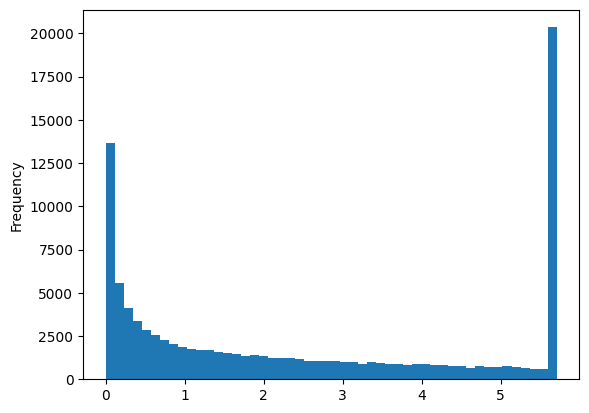

In [11]:
df["log_cost"].plot.hist(bins=50);

In [12]:
(df["cost"] == 300).value_counts(normalize=True)

False    0.80111
True     0.19889
Name: cost, dtype: float64

In [ ]:
all_instances = TSP_from_index_file(
    filepath=DATA_DIR / "TSP" / "TRAIN" / "index.json",
    max_cost=3000.0,
    max_time=300.0,
)

instances = InstanceList()
for i in [0, 200, 400, 600, 800]:
    instances.extend(all_instances[i : i + 20])

for instance in tqdm(instances):
    try:
        instance.calculate_features()
        instance.to_db()
    except Exception as e:
        print(instance, e)

instances_df = DB(DATABASE_DIR / "test-2025_03_23_19_00_48.db").get_instances()
instances_df.to_parquet(DATABASE_DIR / "instances.parquet")